In [9]:
train_path = r'essay_train.txt'
test_path = r'essay_test.txt'
df_train = pd.read_table(train_path,header = None,names=["id", "text", "score1", "score2","score"])
df_test = pd.read_table(test_path,header = None,names=["id", "text"])

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
import sys, nltk, re

def tokenize(line):
    """ Tokenizes  a string
    Input: string to be tokenized
    Output: list of tokens """
    
    orig = line.strip()
    return nltk.word_tokenize(orig)

def pos(tokens):
    """ PoS tags a list of tokens
    Input: list of tokens to be PoS-tagged
    Output: list of tuples with (token, PoS-tag)"""
    
    return nltk.pos_tag(tokens)
    
def penn_2_wordnet(pos_tag):
    """ Converts Penn PoS-tags to Wordnet-style pos tags
    Input: Penn pos tag
    Output: wordnet Pos tag"""
    
    if pos_tag.startswith('N'): 
        return wordnet.NOUN
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    # eliminate punctuation
    elif re.match('[\.:,\(\)]', pos_tag):
        return None
    # default to noun
    else:
        return wordnet.NOUN
    
def get_lemmas(token_tuples):
    """ Lemmatizes a list of token-pos tuples
    Input: list of token-pos tuples using the Penn tagset
    Output: list of tokens"""
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for token_tuple in token_tuples:
        # convert penn pos-tags to wordnet pos-tags
        pos = penn_2_wordnet(token_tuple[1])
        if pos: 
            lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
        
    return lemmas
    
def count_lemmas(lemma_list):
    """ Count number of unique lemmas
    Input: list of lemmas
    Output: number of unique lemmas"""
    
    return len(set(lemma_list))
    
    
def calculate(essay):
    
    lemma_list = []
    #token_count = 0.0
    
    tokens = tokenize(str(essay).lower())
    #token_count = len(tokens)
    posd = pos(tokens)       
    lemmas = get_lemmas(posd)
    lemma_list += lemmas
    
    lcount = count_lemmas(lemma_list)
    #return float(lcount) / token_count
    return lcount
    
def poslist(essay):
    tokens = tokenize(str(essay).lower())
    poslist = []
    p = pos(tokens)
    for pp in p:
        poslist.append(pp[1])
        
    return ' '.join(poslist)
    
def comma_count(essay):
    
    return poslist(essay).count(',')

def posngram(essay):
    #POS-tag essay
    tokens = tokenize(str(essay).lower())
    posd = pos(tokens)
    
    # unigrams
    ugs = set()
    for p in posd:
        ugs.add(p[1])
        
    # bigrams
    bgs = set()
    for i in range(0, len(posd)-1):
        bi = (posd[i][1], posd[i+1][1])
        bgs.add(bi)

    # trigrams
    tgs = set()
    for i in range(0, len(posd)-2):
        tgs.add((posd[i][1], posd[i+1][1], posd[i+2][1]))

    return ugs, bgs, tgs
        

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
# getting binarized pos-ngrams    
pos = df_train.text.apply(poslist)

In [5]:
cv = CountVectorizer(lowercase=False, ngram_range=(1,3), binary=True)
ngs = cv.fit_transform(list(pos))
posngrams = ngs.toarray()

In [33]:
n_train = posngrams[:,np.where(posngrams.sum(axis=0)>10)[0]]

In [32]:
posngrams[:,np.where(posngrams.sum(axis=0)>10)[0]].shape

(1200, 3888)

In [11]:
pos_test = df_test.text.apply(poslist)

In [12]:
ngs_test = cv.transform(pos_test).toarray()

In [14]:
ngs_test.shape

(550, 10404)

In [15]:
posngrams.shape

(1200, 10404)

In [34]:
n_test = ngs_test[:,np.where(posngrams.sum(axis=0)>10)[0]]

In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
from textblob import Word
from nltk import ngrams
from textstat.textstat import textstat
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def get_sat_word(path):
    with open(path, 'r') as f:
        sat = f.read()
    sat_words = []
    for sentence in sat.split('\n'):
        if len(sentence) < 1:
            continue
        sat_words.append(sentence.split()[0])
    return sat_words


# 1）长度相关
def form_counts(content):
    """
    :param sentence:
    :return: 单词数word_count,句子数sentence_count,每个句子的平均单词数avg_sentence_len
              拼写错误单词数spelling_errors,长单词数long_word
    """
    char_count = len(content)
    words = nltk.word_tokenize(content.strip())  # 会自动滤除标点符号/lower
    word_count = len(words)  # 单词数

    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    sents = sent_detector.tokenize(content.strip())
    sentence_count = len(sents)  # 句子数

    if sentence_count != 0:
        avg_sentence_len = word_count / sentence_count  # 每个句子的平均单词数
    else:
        avg_sentence_len = 0

    spelling_errors = sum([Word(word).spellcheck()[0][0] != word for word in words])  # 拼写错误的单词数
    long_word = sum([len(word) >= 7 for word in words])  # 长单词数

    exc_count = words.count('!')
    que_count = words.count('?')

    stopwords = set(nltk.corpus.stopwords.words("english"))
    sat_words = get_sat_word('SAT_words')
    stopwords_num = 0
    sat_num = 0
    for word in words:
        if word in stopwords:
            stopwords_num += 1
        if word in sat_words:
            sat_num += 1

    return char_count, word_count, sentence_count, avg_sentence_len, spelling_errors, \
           long_word, exc_count, que_count, stopwords_num, sat_num


# 2) language model counts
def ngrams_counts(content):
    words = nltk.word_tokenize(content.strip())  # 会自动滤除标点符号/lower
    sents = " ".join(words)

    unigrams = [grams for grams in ngrams(sents.split(), 1)]
    bigrams = [grams for grams in ngrams(sents.split(), 2)]
    trigram = [grams for grams in ngrams(sents.split(), 3)]

    unigrams_count = len([(item[0], unigrams.count(item)) for item in sorted(set(unigrams))])
    bigrams_count = len([(item, bigrams.count(item)) for item in sorted(set(bigrams))])
    trigrams_count = len([(item, trigram.count(item)) for item in sorted(set(trigram))])

    return unigrams_count, bigrams_count, trigrams_count


# 3) POS counts
def pos_counts(content):
    noun_count, adj_count, adv_count, verb_count, fw_count = 0, 0, 0, 0, 0

    words = nltk.word_tokenize(content)
    tags = nltk.pos_tag(words)
    for tag in tags:
        if tag[1].startswith("NN"):
            noun_count += 1
        elif tag[1].startswith("JJ"):
            adj_count += 1
        elif tag[1].startswith("RB"):
            adv_count += 1
        elif tag[1].startswith("VB"):
            verb_count += 1
        elif tag[1].startswith("FW"):
            fw_count += 1
    return noun_count, adj_count, adv_count, verb_count, fw_count


# # 4) getFeature
# def get_dataframe(content):
#     features = pd.DataFrame()

#     features['word_count'],features['sentence_count'],features['avg_sentence_len'],\
#     features['spelling_errors'],features['long_word'] = form_counts(content)

#     features['unigrams_count'],features['bigrams_count'],features['trigrams_count'] = ngrams_counts(content)
#     features['noun_count'], features['adj_count'], features['adv_count'],features['verb_count'], features['fw_count'] = pos_counts(content)

#     return features
def sentiment_tagger(sid = SentimentIntensityAnalyzer(),sent_detector = nltk.data.load('tokenizers/punkt/english.pickle'),essay = None):
    neg_sentiment,neu_sentiment,pos_sentiment = 0, 0 ,0
    sents = sent_detector.tokenize(essay.strip())

    for sent in sents:
        ss = sid.polarity_scores(sent)
        for k in sorted(ss):
            if k == 'neg':
                neg_sentiment += ss[k]
            elif k == 'neu':
                neu_sentiment += ss[k]
            elif k == 'pos':
                pos_sentiment += ss[k]
    return neg_sentiment,neu_sentiment,pos_sentiment

def Readability(df_train):
    syllable_count = df_train.text.apply(textstat.syllable_count)
    flesch_reading_ease = df_train.text.apply(textstat.flesch_reading_ease)
    smog_index = df_train.text.apply(textstat.smog_index)
    flesch_kincaid_grade = df_train.text.apply(textstat.flesch_kincaid_grade)
    coleman_liau_index = df_train.text.apply(textstat.coleman_liau_index)
    automated_readability_index = df_train.text.apply(textstat.automated_readability_index)
    dale_chall_readability_score = df_train.text.apply(textstat.dale_chall_readability_score)
    difficult_words = df_train.text.apply(textstat.difficult_words)  # 困难单词数
    linsear_write_formula = df_train.text.apply(textstat.linsear_write_formula)
    gunning_fog = df_train.text.apply(textstat.gunning_fog)
    return np.c_[syllable_count, flesch_reading_ease, smog_index, flesch_kincaid_grade, coleman_liau_index,
                 automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog]
# 4) getFeature
def get_features(df_train):
    contents = list(df_train.text)
    read = Readability(df_train)
    features = []
    for content in contents:
        char_count, word_count, sentence_count, avg_sentence_len, spelling_errors, \
        long_word, exc_count, que_count, stopwords_num, sat_num = form_counts(content)
        unigrams_count, bigrams_count, trigrams_count = ngrams_counts(content)
        noun_count, adj_count, adv_count, verb_count, fw_count = pos_counts(content)
        neg_sentiment, neu_sentiment, pos_sentiment = sentiment_tagger(content)
        feature = np.c_[char_count, word_count, sentence_count, avg_sentence_len, spelling_errors,
                        long_word, exc_count, que_count, stopwords_num, sat_num, unigrams_count,
                        bigrams_count, trigrams_count, noun_count, adj_count, adv_count, verb_count, fw_count,
                        neg_sentiment, neu_sentiment, pos_sentiment,]
        features.append(feature[0])
    return np.c_[features,read]



/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
read_train = Readability(df_train)
senti_train = np.array([sentiment_tagger(essay=essay) for essay in df_train.text])

In [7]:
read_test = Readability(df_test)
senti_test = np.array([sentiment_tagger(essay=essay) for essay in df_test.text])

In [9]:
bi_features= np.c_[read_train,senti_train]

In [ ]:
with open('readp.pickle','wb') as f:
    pickle.dump([read_train,senti_train,read_test,senti_test],f)

In [67]:
bi_features

array([[  4.38000000e+02,   7.81400000e+01,   8.80000000e+00, ...,
          5.13900000e+00,   2.45840000e+01,   2.27700000e+00],
       [  5.72000000e+02,   5.64500000e+01,   1.23000000e+01, ...,
          2.63900000e+00,   2.09500000e+01,   1.41000000e+00],
       [  3.24000000e+02,   5.17200000e+01,   1.33000000e+01, ...,
          6.34000000e-01,   4.08000000e+00,   2.87000000e-01],
       ..., 
       [  4.31000000e+02,   7.49000000e+01,   9.10000000e+00, ...,
          5.65000000e-01,   2.06690000e+01,   2.76600000e+00],
       [  5.84000000e+02,   8.31500000e+01,   8.70000000e+00, ...,
          4.09000000e-01,   2.78400000e+01,   4.75100000e+00],
       [  7.84000000e+02,   8.64400000e+01,   8.80000000e+00, ...,
          1.11600000e+00,   2.85000000e+01,   4.38500000e+00]])

In [ ]:
train_features = get_features(list(df_train.text))
test_features = get_features(list(df_test.text))
with open('data.pickle','wb') as f:
    pickle.dump([train_features,test_features], f)

In [ ]:
import sklearn
import numpy as np
# Import all of the scikit learn stuff
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import warnings
# Suppress warnings from pandas library
warnings.filterwarnings("ignore", category=DeprecationWarning,
module="pandas", lineno=570)

def compute(df):
    
    """LSA computation
    
    Input: pandas dataframe
    Output: score of the most similar essay to the first essay
    """
    
    # get file's index
    ind = df.name  
    es = df[0]
    essay = df[1]
    
    trainfiles = \
    pd.DataFrame.from_csv('data/training_set_rel3.tsv',\
    sep="\t")
    # drop test file from training if present
    trainfiles.drop(ind, inplace=True)
    
    scores = trainfiles[trainfiles.essay_set == es].domain1_score
    # create training matrix
    testfile = pd.Series(essay)    
    trainfiles = trainfiles[trainfiles.essay_set == es].essay
    data = testfile.append(trainfiles)
    
    
    # create DTM
    vectorizer = CountVectorizer(min_df = 1, stop_words = 'english')
    dtm = vectorizer.fit_transform(data)
        
    
    # Fit LSA
    lsa = TruncatedSVD(100, algorithm = 'randomized')
    dtm_lsa = lsa.fit_transform(dtm)
    dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
    
    similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T)
    simdf = pd.DataFrame(similarity,index=data.index, columns=data.index)
    
    closest_id = simdf.iloc[0][1:].idxmax()
    
    return scores[closest_id]

In [46]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import  mean_squared_error
from sklearn.svm import  SVR
from scipy.stats import pearsonr
import pickle
import numpy as np
import time
from sklearn.linear_model import LassoCV

/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:

def model_random_forest(Xtrain,Xtest,y_train,add):
    X_train = Xtrain
    # print(len(X_train[0]))
    rfr = RandomForestRegressor(n_jobs=-1, random_state=10,oob_score=True)
    param_grid ={'n_estimators': [40]}
    #'n_estimators': [300]
    # 'n_estimators': list(r,ange(30,60130)), ,"max_depth":list(range(40,61,10)),"max_features":list(range(120,211,30)),min_samples_split':list(range(20,201,20)),  'min_samples_leaf':list(range(10,80,10))
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring= None, iid=False, cv=10)
    model.fit(X_train, y_train)
    # model.grid_scores_, model.best_params_, model.best_score_
#     print('Random forecast classifier...')
#     print('Best Params:')
#     print(model.best_params_)
#     print('Best CV Score:')
    print(-model.best_score_)
    y_pred = model.predict(Xtest)
    final1 = model.predict(add)
    return y_pred, final1



def model_GBR(Xtrain,Xtest,y_train,add):
    X_train = Xtrain
    rfr = GradientBoostingRegressor(random_state=10,learning_rate= 0.01,loss= "ls")
    param_grid = {'n_estimators': [50]}
    # 'n_estimators': list(range(30,601,30)), ,"max_depth":list(range(40,61,10)),"max_features":list(range(120,211,30)),min_samples_split':list(range(20,201,20)),  'min_samples_leaf':list(range(10,80,10))
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring= None, iid=False, cv=10)
    model.fit(X_train, y_train)
#     print('Best Params:')
#     print(model.best_params_)
    y_pred = model.predict(Xtest)
    final2 = model.predict(add)
    return y_pred,final2

def model_XG(Xtrain,Xtest,y_train,add):
    clf = XGBRegressor(nthread=4,n_estimators=100)
    clf.fit(Xtrain,y_train)
    y_pred = clf.predict(Xtest)
    final3 = clf.predict(add)
    return y_pred,final3

def model_cv(Xtrain,Xtest,y_train,add):
    lscv = LassoCV()
    lscv.fit(Xtrain, y_train)
    y_pred = lscv.predict(Xtest)
    final = lscv.predict(add)
    return y_pred,final

In [36]:
with open('train.pickle','rb') as f:
    train_feature = pickle.load(f)

In [37]:
with open('test.pickle','rb') as f:
    test_feature = pickle.load(f)

In [38]:
with open('readp.pickle','rb') as f:
    read_train,senti_train,read_test,senti_test = pickle.load(f)

In [39]:
X_train = []
for feature in train_feature:
    X_train.append(feature[0])
X_train = np.c_[np.array(X_train),read_train,senti_train,n_train]      

In [40]:
X_test = []
for feature in test_feature:
    X_test.append(feature[0])
X_test = np.c_[np.array(X_test),read_test,senti_test,n_test]

In [41]:
X_train.shape

(1200, 3919)

In [42]:
scores = np.c_[list(df_train.score1),list(df_train.score2),list(df_train.score)]

In [43]:
len(scores[:,1])

1200

In [7]:
import pandas as pd
import pickle
import sys, nltk, re
import pandas as pd
import numpy as np
import pickle
import time
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import Word
from textstat.textstat import textstat
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import  train_test_split
from sklearn.metrics import  mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import  SVR
from sklearn.linear_model import LassoCV
from scipy.stats import pearsonr


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20

In [5]:
train_dense_features = pd.read_csv('train_dense_features.csv')
test_dense_features = pd.read_csv('test_dense_features.csv')
with open('sparse.pickle','rb') as f:
    train_sparse_features,test_sparse_features = pickle.load(f)

In [10]:
scores = np.c_[list(df_train.score1),list(df_train.score2),list(df_train.score)]
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(train_dense_features)
X_test = scaler.transform(test_dense_features)

In [11]:
x_train, x_cross, y_train, y_cross = train_test_split(X_train, scores, test_size=0.2, random_state=1021)

In [12]:
x = x_train
xc = x_cross
xt = X_test

In [16]:
p = []
for i in range(1,x.shape[1]):
    xtrain, xcross,xtest = x[:,:i],xc[:,:i],xt[:,:i]
    y_pred, final1_1= model_random_forest(xtrain,xcross, y_train[:,0],xtest)
    Y_pred, final1_2 = model_GBR(xtrain,xcross, y_train[:,0],xtest)
    xg_pred, final1_3 = model_XG(xtrain,xcross, y_train[:,0],xtest)
    cv_pred, final1_4 = model_cv(xtrain,xcross, y_train[:,0],xtest)
    y_pred2, final2_1= model_random_forest(xtrain,xcross, y_train[:,1],xtest)
    Y_pred2, final2_2 = model_GBR(xtrain,xcross, y_train[:,1],xtest)
    xg_pred2, final2_3 = model_XG(xtrain,xcross, y_train[:,1],xtest)
    cv_pred2, final2_4 = model_cv(xtrain,xcross, y_train[:,1],xtest)
    print("The peasorn of %d:"%i, pearsonr((Y_pred+Y_pred2+y_pred+y_pred2+xg_pred+xg_pred2+cv_pred+cv_pred2)/4, y_cross[:,2])[0])
    p.append(pearsonr((Y_pred+Y_pred2+y_pred+y_pred2+xg_pred+xg_pred2+cv_pred+cv_pred2)/4, y_cross[:,2])[0])

0.49368735097014016
0.48505539911120055
The peasorn of 1: 0.0668767313805
-0.433200094883827
-0.47510836493598524
The peasorn of 2: 0.846036127453
-0.4622248340794354
-0.5159992284510437
The peasorn of 3: 0.841882574314
-0.47849662459162046
-0.5244042608823873
The peasorn of 4: 0.851095661312
-0.48619185247424923
-0.5345557809937479
The peasorn of 5: 0.852367769783
-0.49507646071886524
-0.5433493370947751
The peasorn of 6: 0.851380191801
-0.5217664014421772
-0.562489966618961
The peasorn of 7: 0.864219079567
-0.5377219920692
-0.5681174622108578
The peasorn of 8: 0.863846874672
-0.5437971453795999
-0.5691666932072583
The peasorn of 9: 0.864538243785
-0.5418133673106615
-0.5802454070166152
The peasorn of 10: 0.869447737923
-0.5511697473540098
-0.5828872348183214
The peasorn of 11: 0.871297581212
-0.5505510649716685
-0.5846257320601742
The peasorn of 12: 0.872033271277
-0.5594676472710761
-0.5993240422629131
The peasorn of 13: 0.873632296412
-0.5574938378210104
-0.6016828813238035
The pea

/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 23: 0.870062888488
-0.5691016918753016
-0.6121081840319624


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 24: 0.87055262927
-0.5692471726313759
-0.6127826750012633


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 25: 0.869952040898
-0.5737012327605564


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.6079323929368728


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 26: 0.86932999972
-0.5713933839210799


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.6102149209951581


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 27: 0.867194412225
-0.5709093737197862


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.610185920058295


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 28: 0.870756284077
-0.577125381815281


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.6122155460117447


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 29: 0.870352057263
-0.5745425955482821


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.6137787999530672


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 30: 0.869385121636
-0.5805076509827425


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.6147637199605517


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The peasorn of 31: 0.867393187229
-0.5786607312034497


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.6217237460084508
The peasorn of 32: 0.867203287271


/home/liuzhiqiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [72]:
xtrain, xcross,xtest = x,xc,xt
y_pred, final1_1= model_random_forest(xtrain,xcross, y_train[:,0],xtest)
Y_pred, final1_2 = model_GBR(xtrain,xcross, y_train[:,0],xtest)
xg_pred, final1_3 = model_XG(xtrain,xcross, y_train[:,0],xtest)
cv_pred, final1_4 = model_cv(xtrain,xcross, y_train[:,0],xtest)
y_pred2, final2_1= model_random_forest(xtrain,xcross, y_train[:,1],xtest)
Y_pred2, final2_2 = model_GBR(xtrain,xcross, y_train[:,1],xtest)
xg_pred2, final2_3 = model_XG(xtrain,xcross, y_train[:,1],xtest)
cv_pred2, final2_4 = model_cv(xtrain,xcross, y_train[:,1],xtest)
print("The peasorn of 18:", pearsonr((Y_pred+Y_pred2+y_pred+y_pred2+xg_pred+xg_pred2+cv_pred+cv_pred2)/4, y_cross[:,2])[0])

-0.6023247312041085
-0.6285062209453064
The peasorn of 18: 0.983181533596


In [60]:
np.where(x.sum(axis=0)==0)

(array([ 306, 1131]),)

In [58]:
np.where(x==0)

(array([  0,   0,   0, ..., 959, 959, 959]),
 array([   6,    7,   17, ..., 3916, 3917, 3918]))

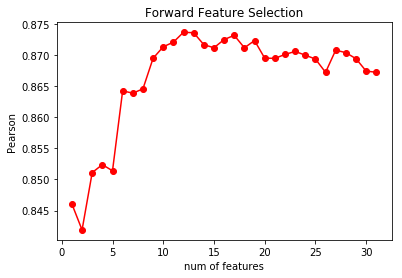

In [22]:
import matplotlib.pyplot as plt
from pylab import * 
x=range(len(p))
plt.plot(x[1:], p[1:], 'ro-')
title('Forward Feature Selection')
xlabel('num of features')
ylabel('Pearson')
plt.show()

In [73]:
# print("The MSE of RandomForest:",mean_squared_error(y_pred,y_cross))
# print("The MSE of GradientBoostingRegression:", mean_squared_error(Y_pred, y_cross))
# print("The MSE of XGboost", mean_squared_error(xg_pred, y_cross))
# print("The Peasorn of RandomForest:", pearsonr(y_pred, y_cross)[0])
# print("The peasorn of GradientBoostingRegression:", pearsonr(Y_pred, y_cross)[0])
# print("The Peasorn of Xgboost:", pearsonr(xg_pred, y_cross)[0])
# print("The mse of all:",mean_squared_error((Y_pred+y_pred+xg_pred)/3, y_cross))
print("The peasorn of all:", pearsonr((Y_pred+Y_pred2+y_pred+y_pred2+xg_pred+xg_pred2+cv_pred+cv_pred2)/4, y_cross[:,2])[0])

The peasorn of all: 0.983181533596


In [21]:
!pip jupyter_contrib_nbextensions

ERROR: unknown command "jupyter_contrib_nbextensions"


In [74]:
len(df_test.id)

550

In [75]:
with open("submission_sample.txt", "w") as f:
    for i in range(550):
        f.write(str(df_test.id[i]) + "," + str((final1_1[i]+final1_2[i]+final1_3[i]+final2_1[i]+final2_2[i]+final2_3[i])/3) + "\n")
    #         # f.write(y_ids[i] + "," + str(y_pred[i]) + "\n")